In [102]:
import numpy as np
import matplotlib.pyplot as plt


In [103]:
class Soplo:
    #rarely changed parameters
    g = 1.2
    R = 363
    T_k = 3650
    phi_ras = 0.992
    
    def __init__(self, p_k, p_a, F_cr):
        #what is given to initialize class object
        self._p_k = p_k
        self._p_a = p_a
        self._F_cr = F_cr
        
        #everuthing below calculates automatically
        
        #nozzle parameters
        self._R_cr = np.sqrt(F_cr / np.pi) #critical section radius
        self._r_skr = 0.45 * self._R_cr #radius of critical section exit
        self._R_skr = 1.5 * self._R_cr #radius of critical section entrance
        self._theta_a = np.arccos(2 * self.phi_ras-1) #line slope on exit section
        self._F_a_ = ((((2/(self.g + 1)) ** (1/(self.g - 1))) * np.sqrt((self.g - 1)/(self.g + 1)))
                      / np.sqrt((p_a/p_k) ** (2/self.g) - (p_a/p_k) ** ((self.g + 1)/self.g))) #exit to critical section area ratio
        self._F_a = self._F_a_ * self._F_cr #exit section area
        self._R_a = np.sqrt(self._F_a / np.pi) #exit section radius
        self._rad_ratio = self._R_a/self._R_cr #exit to critical radius ratio
        self._theta_m = 1 #line slope on entrance section (tangential to radius)
        self._length = 1 #nozzle length
        
        #construction geometry parameters
        #_cr - parameters of tangent to rounded radius of critical section exit
        #_a - parameters of line on nozzle exit 
        #update after adding theta_m and lenrat using add_params_function
        
        self._k_cr = 1 #_cr line slope
        self._x_kas = 0 #tangential point of _cr line & rounded radius
        self._b_cr = 1 #_cr line y-intercept
        self._k_a = 0 #_a line slope
        self._b_a = 0 #_a line y-intercept
        self._pt = 0 #x coordinate of two lines intercept
        
    def add_params_46(self, theta_m, lenrat):
        #adds parameters from Dobrovolsky's p.46
        self._theta_m = theta_m * np.pi / 180
        self._length = lenrat * self._R_cr
        #parameters update
        self._k_cr = np.tan(self._theta_m)
        self._x_kas = self._k_cr * self._r_skr / np.sqrt(1 + self._k_cr **2)
        self._b_cr = self.rads(self._x_kas, self._r_skr) - self._x_kas * self._k_cr
        self._k_a =  np.tan(self._theta_a)
        self._b_a = - np.tan(self._theta_a) * self._length + self._R_a
        self._pt = abs(self._b_a - self._b_cr) / abs(self._k_a - self._k_cr) 
    
    def rads(self, x, rad):#rounding radius builder
        return -np.sqrt(rad**2-x**2)+self._R_cr+rad
    
    def line_kas(self, x):#_cr line builder
        return(self._b_cr + self._k_cr * x)
    
    def line_ext(self, x):#_a line builder
        return(self._k_a * x + self._b_a)
    


In [104]:
s = Soplo(5.92, 0.059, 0.01)
print('Current nozzle parameters')
s.__dict__

Current nozzle parameters


{'_p_k': 5.92,
 '_p_a': 0.059,
 '_F_cr': 0.01,
 '_R_cr': 0.05641895835477563,
 '_r_skr': 0.025388531259649034,
 '_R_skr': 0.08462843753216345,
 '_theta_a': 0.17912481487888987,
 '_F_a_': 11.901661437014557,
 '_F_a': 0.11901661437014557,
 '_R_a': 0.19463854955825463,
 '_rad_ratio': 3.449878466991925,
 '_theta_m': 1,
 '_length': 1,
 '_k_cr': 1,
 '_x_kas': 0,
 '_b_cr': 1,
 '_k_a': 0,
 '_b_a': 0,
 '_pt': 0}

In [105]:
s.add_params_46(28, 7.33)#adding p.46 parameters
print('All nozzle parameters')
s.__dict__

All nozzle parameters


{'_p_k': 5.92,
 '_p_a': 0.059,
 '_F_cr': 0.01,
 '_R_cr': 0.05641895835477563,
 '_r_skr': 0.025388531259649034,
 '_R_skr': 0.08462843753216345,
 '_theta_a': 0.17912481487888987,
 '_F_a_': 11.901661437014557,
 '_F_a': 0.11901661437014557,
 '_R_a': 0.19463854955825463,
 '_rad_ratio': 3.449878466991925,
 '_theta_m': 0.4886921905584123,
 '_length': 0.4135509647405054,
 '_k_cr': 0.5317094316614788,
 '_x_kas': 0.011919193447305871,
 '_b_cr': 0.053053199478763705,
 '_k_a': -0.18106550773430974,
 '_b_a': 0.26951836496300785,
 '_pt': 0.30369356934425795}

In [106]:
def returnlinear(x1, y1, x2, y2):#returns slope and y-intersept using two points
    a = (y2-y1)/(x2-x1)
    b = y1- x1 * (y2-y1)/(x2-x1)
    return a,b

def points_finder(n, X_cr, Y_cr, X_p, Y_p_cr, Y_p_a, X_a, Y_a):
    xs_cr = [i for i in X_cr + (X_p-X_cr)*np.arange(0, n+1)/n] #X coordinates of _cr line points
    ys_cr = [s._k_cr* x + s._b_cr for x in xs_cr]#Y coordinates of _cr line points

    xs_a = [i for i in X_p + (X_a-X_p)*np.arange(0, n+1)/n]#X coordinates of _a line points
    ys_a = [s._k_a* x + s._b_a for x in xs_a]#Y coordinates of _a line points
    

    #gets slopes and y-intercepts of the lines
    a_s, b_s = returnlinear(np.array(xs_cr), np.array(ys_cr),np.array(xs_a),np.array(ys_a))
    
    points_x = [X_cr]
    points_y = [Y_cr]
    #searching for the resulting points (interceptions with lowest y)
    for i in range(len(a_s)-1):
        point_x = []
        point_y = []
        for j in range(i+1, len(a_s)):
            x = ((b_s[j]-b_s[i])/(a_s[i]-a_s[j]))
            point_x.append(x)
            y = a_s[i] * (b_s[j]-b_s[i])/(a_s[i]-a_s[j]) + b_s[i]
            point_y.append(y)
        points_x.append(point_x[point_y.index(min(point_y))])
        points_y.append(point_y[point_y.index(min(point_y))])  
        plt.plot([xs_cr[i],xs_a[i]] , [ys_cr[i],ys_a[i]],  linewidth=0.25, color='k')
    #building the supporting graph    
    points_x.append(X_a)
    points_y.append(Y_a)
    plt.axis('scaled')
    plt.show()
    return points_x, points_y


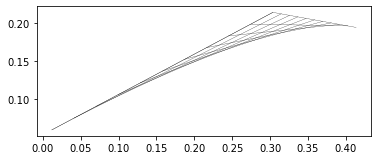

In [107]:
#used points coordinates: 
#tangent point to rounded radius of critical section exit
X_cr = s._x_kas
Y_cr = s._k_cr* X_cr+ s._b_cr
#interception point
X_p = s._pt
Y_p_cr = s._k_cr* X_p + s._b_cr
Y_p_a = s._k_a * X_p + s._b_a
#terminal point on exit section
X_a = s._length
Y_a = s._R_a
#number for lines division
n = 10
#lines _cr and _a
x_line_kas = np.linspace(s._x_kas, s._pt, 100)
x_line_a = np.linspace(s._pt, s._length, 100)
plt.plot(x_line_kas, s.line_kas(x_line_kas), linewidth=0.25, color='k')
plt.plot(x_line_a, s.line_ext(x_line_a), linewidth=0.25, color='k')

#function call
points_x, points_y = points_finder(n, X_cr, Y_cr, X_p, Y_p_cr, Y_p_a, X_a, Y_a)


In [108]:
#creating nozzle points
#x points for rounded radius on critical section entrance
x_do = list(np.linspace(-s._R_skr/2, 0, 100))
#x points for rounded radius on critical section exit
x = list(np.linspace(0, s._x_kas, 100))
#combining all x-coordinates
X = x_do+x+points_x
#combining all y-coordinates
Y = [s.rads(i, s._R_skr) for i in x_do] + [s.rads(i, s._r_skr) for i in x] + points_y

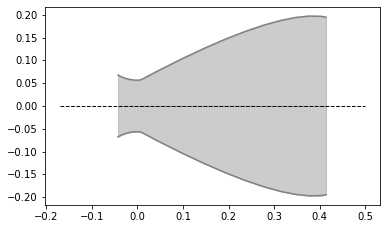

In [109]:
#axis of symmetry
axis = np.linspace(-2*s._R_skr, s._length+s._R_skr, 10)
plt.plot(axis , np.zeros(axis.shape[0]), '--', linewidth=1, color='k' )
#building the contour and filling the nozzle with color
plt.fill_between(X, Y, alpha=0.4, color='gray')
plt.plot(X, Y, color='gray')

plt.fill_between(X, [-i for i in Y], alpha=0.4, color='gray')
plt.plot(X, [-i for i in Y],'gray')

plt.axis('scaled')
plt.show()
